In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10


In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Final_caruid_csv/BARLEY_1100.csv')

df.pop("Area")
df.head()

,Year,Yield,SumPcpn15_17,SumPcpn16_18,SumPcpn17_19,SumPcpn18_20,SumPcpn19_21,SumPcpn20_22,SumPcpn21_23,SumPcpn22_24,SumPcpn23_25,SumPcpn24_26,SumPcpn25_27,SumPcpn26_28,SumPcpn27_29,SumPcpn28_30,SumPcpn29_31,SumPcpn30_32,SumPcpn31_33,SumPcpn32_34,SumPcpn33_35,SumPcpn34_36,SumPcpn35_37,SumPcpn36_38,SumPcpn37_39,SumEGDD_C15_17,SumEGDD_C16_18,SumEGDD_C17_19,SumEGDD_C18_20,SumEGDD_C19_21,SumEGDD_C20_22,SumEGDD_C21_23,SumEGDD_C22_24,SumEGDD_C23_25,SumEGDD_C24_26,SumEGDD_C25_27,SumEGDD_C26_28,SumEGDD_C27_29,SumEGDD_C28_30,SumEGDD_C29_31,...,AvgPrcnAWHC18_20,AvgPrcnAWHC19_21,AvgPrcnAWHC20_22,AvgPrcnAWHC21_23,AvgPrcnAWHC22_24,AvgPrcnAWHC23_25,AvgPrcnAWHC24_26,AvgPrcnAWHC25_27,AvgPrcnAWHC26_28,AvgPrcnAWHC27_29,AvgPrcnAWHC28_30,AvgPrcnAWHC29_31,AvgPrcnAWHC30_32,AvgPrcnAWHC31_33,AvgPrcnAWHC32_34,AvgPrcnAWHC33_35,AvgPrcnAWHC34_36,AvgPrcnAWHC35_37,AvgPrcnAWHC36_38,AvgPrcnAWHC37_39,NDVI18_20,NDVI19_21,NDVI20_22,NDVI21_23,NDVI22_24,NDVI23_25,NDVI24_26,NDVI25_27,NDVI26_28,NDVI27_29,NDVI28_30,NDVI29_31,NDVI30_32,NDVI31_33,NDVI32_34,NDVI33_35,NDVI34_36,NDVI35_37,NDVI36_38,NDVI_MAX
0,1987,59.1,32.316667,27.766667,37.366667,49.216667,31.633333,31.316667,39.683333,83.950000,82.966667,89.966667,44.366667,36.066667,5.666667,13.050000,20.816667,33.083333,34.033333,38.316667,28.966667,34.783333,81.916667,111.250000,122.250000,30.041667,30.491667,42.658333,60.033333,85.450000,102.266667,114.591667,146.108333,166.141667,188.341667,213.575000,260.341667,304.233333,321.166667,290.575000,...,0.899921,0.891667,0.863810,0.838889,0.860476,0.876190,0.887222,0.837857,0.732619,0.564921,0.385714,0.255714,0.191587,0.145714,0.122540,0.092857,0.111825,0.233413,0.468333,0.698492,0.302127,0.338232,0.370780,0.407115,0.442306,0.476672,0.502294,0.529814,0.550871,0.562329,0.561515,0.551753,0.538061,0.507782,0.476115,0.452257,0.451697,0.454605,0.450840,0.569374
1,1988,55.7,73.950000,91.716667,54.766667,51.400000,55.833333,77.633333,63.283333,55.266667,57.916667,81.916667,68.250000,48.883333,49.133333,52.766667,55.016667,36.050000,76.166667,71.900000,86.766667,59.783333,76.733333,61.716667,58.900000,2.275000,17.858333,49.700000,99.816667,145.308333,131.666667,117.000000,131.058333,190.391667,212.166667,245.566667,262.908333,297.450000,292.758333,314.533333,...,0.881111,0.884048,0.908571,0.909683,0.895317,0.881270,0.882540,0.861905,0.790556,0.691905,0.609921,0.511667,0.390476,0.371905,0.401508,0.479206,0.475873,0.500159,0.549524,0.598254,0.301431,0.352259,0.395926,0.424704,0.431013,0.446988,0.473555,0.506423,0.520625,0.520702,0.509849,0.500258,0.487528,0.472792,0.459555,0.450645,0.446994,0.449789,0.452501,0.536064
2,1989,68.7,49.716667,69.050000,79.666667,79.533333,80.433333,42.700000,66.933333,49.633333,50.100000,40.983333,29.133333,63.516667,48.983333,59.816667,43.400000,57.500000,50.566667,56.883333,61.966667,53.333333,54.250000,56.950000,82.600000,2.366667,40.541667,78.358333,128.583333,149.775000,171.091667,176.258333,164.758333,189.291667,208.283333,251.025000,252.875000,261.808333,279.291667,295.841667,...,0.880556,0.876825,0.864921,0.878889,0.888571,0.880238,0.825476,0.715397,0.668095,0.585476,0.497143,0.339524,0.268016,0.243175,0.278571,0.311349,0.334524,0.323889,0.400873,0.571825,0.278392,0.329570,0.375786,0.409729,0.426889,0.452938,0.485146,0.515192,0.536729,0.548501,0.551908,0.548083,0.537827,0.523564,0.511362,0.506626,0.507242,0.495402,0.475099,0.554770
3,1990,50.6,66.750000,60.033333,52.650000,98.183333,99.433333,129.850000,88.850000,59.200000,59.516667,53.866667,63.733333,19.250000,24.133333,62.216667,145.700000,182.200000,161.350000,71.800000,44.716667,34.716667,41.533333,84.066667,67.833333,12.975000,34.875000,53.808333,52.600000,38.175000,70.258333,127.875000,202.891667,212.658333,242.050000,229.325000,252.266667,277.591667,322.558333,336.558333,...,0.900397,0.917063,0.912698,0.883095,0.825238,0.806111,0.799841,0.801270,0.707381,0.549921,0.487698,0.549206,0.644127,0.729762,0.703968,0.632063,0.508730,0.424603,0.484444,0.618810,0.299783,0.323364,0.349615,0.381

In [ ]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

full_data = df

train

,Year,Yield,SumPcpn15_17,SumPcpn16_18,SumPcpn17_19,SumPcpn18_20,SumPcpn19_21,SumPcpn20_22,SumPcpn21_23,SumPcpn22_24,SumPcpn23_25,SumPcpn24_26,SumPcpn25_27,SumPcpn26_28,SumPcpn27_29,SumPcpn28_30,SumPcpn29_31,SumPcpn30_32,SumPcpn31_33,SumPcpn32_34,SumPcpn33_35,SumPcpn34_36,SumPcpn35_37,SumPcpn36_38,SumPcpn37_39,SumEGDD_C15_17,SumEGDD_C16_18,SumEGDD_C17_19,SumEGDD_C18_20,SumEGDD_C19_21,SumEGDD_C20_22,SumEGDD_C21_23,SumEGDD_C22_24,SumEGDD_C23_25,SumEGDD_C24_26,SumEGDD_C25_27,SumEGDD_C26_28,SumEGDD_C27_29,SumEGDD_C28_30,SumEGDD_C29_31,...,AvgPrcnAWHC18_20,AvgPrcnAWHC19_21,AvgPrcnAWHC20_22,AvgPrcnAWHC21_23,AvgPrcnAWHC22_24,AvgPrcnAWHC23_25,AvgPrcnAWHC24_26,AvgPrcnAWHC25_27,AvgPrcnAWHC26_28,AvgPrcnAWHC27_29,AvgPrcnAWHC28_30,AvgPrcnAWHC29_31,AvgPrcnAWHC30_32,AvgPrcnAWHC31_33,AvgPrcnAWHC32_34,AvgPrcnAWHC33_35,AvgPrcnAWHC34_36,AvgPrcnAWHC35_37,AvgPrcnAWHC36_38,AvgPrcnAWHC37_39,NDVI18_20,NDVI19_21,NDVI20_22,NDVI21_23,NDVI22_24,NDVI23_25,NDVI24_26,NDVI25_27,NDVI26_28,NDVI27_29,NDVI28_30,NDVI29_31,NDVI30_32,NDVI31_33,NDVI32_34,NDVI33_35,NDVI34_36,NDVI35_37,NDVI36_38,NDVI_MAX
0,1987,59.1,32.316667,27.766667,37.366667,49.216667,31.633333,31.316667,39.683333,83.950000,82.966667,89.966667,44.366667,36.066667,5.666667,13.050000,20.816667,33.083333,34.033333,38.316667,28.966667,34.783333,81.916667,111.250000,122.250000,30.041667,30.491667,42.658333,60.033333,85.450000,102.266667,114.591667,146.108333,166.141667,188.341667,213.575000,260.341667,304.233333,321.166667,290.575000,...,0.899921,0.891667,0.863810,0.838889,0.860476,0.876190,0.887222,0.837857,0.732619,0.564921,0.385714,0.255714,0.191587,0.145714,0.122540,0.092857,0.111825,0.233413,0.468333,0.698492,0.302127,0.338232,0.370780,0.407115,0.442306,0.476672,0.502294,0.529814,0.550871,0.562329,0.561515,0.551753,0.538061,0.507782,0.476115,0.452257,0.451697,0.454605,0.450840,0.569374
1,1988,55.7,73.950000,91.716667,54.766667,51.400000,55.833333,77.633333,63.283333,55.266667,57.916667,81.916667,68.250000,48.883333,49.133333,52.766667,55.016667,36.050000,76.166667,71.900000,86.766667,59.783333,76.733333,61.716667,58.900000,2.275000,17.858333,49.700000,99.816667,145.308333,131.666667,117.000000,131.058333,190.391667,212.166667,245.566667,262.908333,297.450000,292.758333,314.533333,...,0.881111,0.884048,0.908571,0.909683,0.895317,0.881270,0.882540,0.861905,0.790556,0.691905,0.609921,0.511667,0.390476,0.371905,0.401508,0.479206,0.475873,0.500159,0.549524,0.598254,0.301431,0.352259,0.395926,0.424704,0.431013,0.446988,0.473555,0.506423,0.520625,0.520702,0.509849,0.500258,0.487528,0.472792,0.459555,0.450645,0.446994,0.449789,0.452501,0.536064
2,1989,68.7,49.716667,69.050000,79.666667,79.533333,80.433333,42.700000,66.933333,49.633333,50.100000,40.983333,29.133333,63.516667,48.983333,59.816667,43.400000,57.500000,50.566667,56.883333,61.966667,53.333333,54.250000,56.950000,82.600000,2.366667,40.541667,78.358333,128.583333,149.775000,171.091667,176.258333,164.758333,189.291667,208.283333,251.025000,252.875000,261.808333,279.291667,295.841667,...,0.880556,0.876825,0.864921,0.878889,0.888571,0.880238,0.825476,0.715397,0.668095,0.585476,0.497143,0.339524,0.268016,0.243175,0.278571,0.311349,0.334524,0.323889,0.400873,0.571825,0.278392,0.329570,0.375786,0.409729,0.426889,0.452938,0.485146,0.515192,0.536729,0.548501,0.551908,0.548083,0.537827,0.523564,0.511362,0.506626,0.507242,0.495402,0.475099,0.554770
3,1990,50.6,66.750000,60.033333,52.650000,98.183333,99.433333,129.850000,88.850000,59.200000,59.516667,53.866667,63.733333,19.250000,24.133333,62.216667,145.700000,182.200000,161.350000,71.800000,44.716667,34.716667,41.533333,84.066667,67.833333,12.975000,34.875000,53.808333,52.600000,38.175000,70.258333,127.875000,202.891667,212.658333,242.050000,229.325000,252.266667,277.591667,322.558333,336.558333,...,0.900397,0.917063,0.912698,0.883095,0.825238,0.806111,0.799841,0.801270,0.707381,0.549921,0.487698,0.549206,0.644127,0.729762,0.703968,0.632063,0.508730,0.424603,0.484444,0.618810,0.299783,0.323364,0.349615,0.381

In [ ]:
f_columns = list(df.columns)
f_columns.remove("Yield")
f_columns.remove("Year")

from sklearn.preprocessing import MinMaxScaler

f_transformer = MinMaxScaler()
yld_transformer = MinMaxScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
yld_transformer = yld_transformer.fit(train[['Yield']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Yield'] = yld_transformer.transform(train[['Yield']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Yield'] = yld_transformer.transform(test[['Yield']])



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Yield, time_steps)
X_test, y_test = create_dataset(test, test.Yield, time_steps)

print(X_train.shape, y_train.shape)

(29, 1, 160) (29,)


In [ ]:

model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=False
)

In [ ]:
#tf.keras.backend.clear_session()
#y_pred = model.predict(X_test)

In [ ]:
y_train_inv = yld_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = yld_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = yld_transformer.inverse_transform(y_pred)

In [ ]:
full_data.loc[:, f_columns] = f_transformer.transform(full_data[f_columns].to_numpy())
full_data['Yield'] = yld_transformer.transform(full_data[['Yield']])
X_full_data, y_full_data = create_dataset(full_data, full_data.Yield, time_steps)


df_pred = model.predict(X_full_data)
tf.keras.backend.clear_session()
df_pred_inv = yld_transformer.inverse_transform(df_pred)
df_pred_inv

array([[61.921818],
       [57.218327],
       [66.2737  ],
       [59.22287 ],
       [59.880917],
       [53.235905],
       [80.504974],
       [62.065273],
       [68.93096 ],
       [66.566   ],
       [57.309868],
       [60.232853],
       [64.83158 ],
       [55.289207],
       [70.18934 ],
       [51.63028 ],
       [49.03838 ],
       [60.915184],
       [55.091946],
       [68.361374],
       [29.070389],
       [47.18029 ],
       [41.07514 ],
       [75.15654 ],
       [51.794815],
       [65.00785 ],
       [56.38157 ],
       [48.772045],
       [46.996315],
       [70.65567 ],
       [61.717167],
       [50.799698],
       [60.24216 ]], dtype=float32)

In [ ]:
yld_transformer.inverse_transform(y_full_data.reshape(1, -1))

array([[0.31071429, 0.775     , 0.12857143, 0.26071429, 1.        ,
        0.17857143, 0.22142857, 0.24285714, 0.46428571, 0.53571429,
        0.64285714, 0.14285714, 0.64285714, 0.        , 0.67857143,
        0.17857143, 0.39285714, 0.53571429, 0.        , 0.21428571,
        0.07142857, 0.14285714, 0.32142857, 0.39285714, 0.53571429,
        0.59285714, 0.40357143, 0.61071429, 0.66428571, 0.70357143,
        0.66071429, 0.74642857, 0.56785714]])

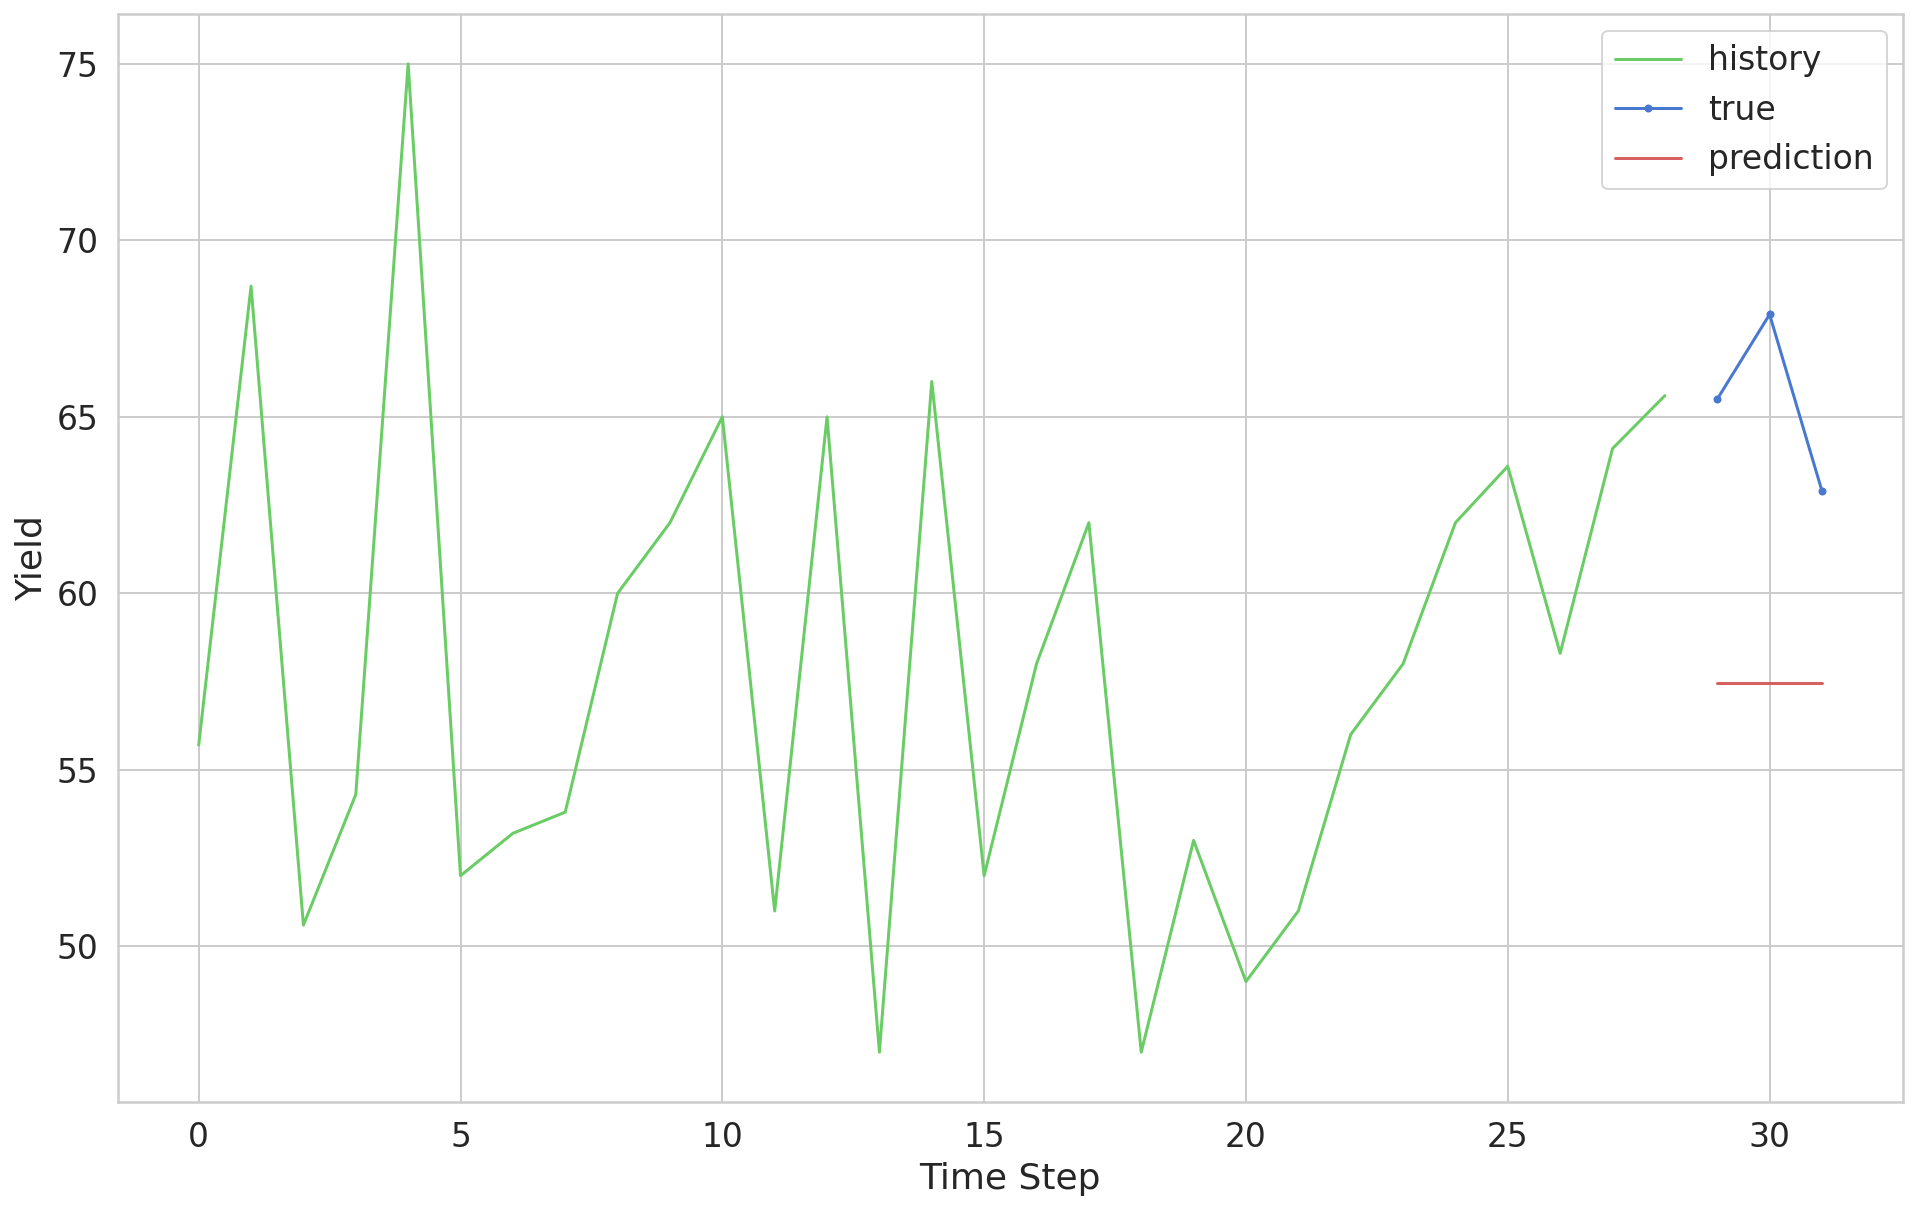

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Yield')
plt.xlabel('Time Step')
plt.legend()
plt.show();